# Ensembles

In [1]:
import time
import datetime
import bz2

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data preparation and overall functions

In [2]:
df = pd.read_csv('data_ML_25_05.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,close,close_change,open,high,low,volume,bb_bbh,bb_bbl,bb_bbm,ATR_10,...,ROCI_40,ROCI_60,ROCI_120,Vortex_diff,Vortex_neg,Vortex_pos,ichimoku_a,ichimoku_b,ichimoku_bl,ichimoku_cl
date,,,,,,,,,,,,,,,,,,,,,
2015-01-19,1.15947,1,1.15614,1.16388,1.15514,141004,1.225656,1.149432,1.187544,0.009608,...,0.000000,0.000000,0.000000,-0.412351,0.876489,0.464137,1.175315,1.18409,1.184090,1.166540
2015-06-08,1.12800,1,1.11023,1.13068,1.10842,220017,1.139031,1.079038,1.109034,0.014026,...,5.179729,4.162819,-2.714171,0.011417,0.978159,0.989576,1.113830,1.09936,1.114305,1.113355
2015-06-09,1.12926,1,1.12802,1.13454,1.12140,224134,1.135281,1.081274,1.108277,0.013938,...,4.427676,5.162876,-2.189617,0.071010,0.967493,1.038503,1.113830,1.09936,1.114305,1.113355
2015-06-10,1.13099,1,1.12926,1.13865,1.12600,246733,1.134962,1.081451,1.108207,0.013809,...,4.041175,5.017875,-2.624261,0.027184,0.995233,1.022417,1.113997,1.09936,1.114305,1.113690
2015-06-11,1.12458,0,1.13099,1.13315,1.11820,203152,1.136311,1.081135,1.108723,0.013923,...,3.500069,3.460077,-0.889245,-0.028576,1.015807,0.987231,1.114712,1.09936,1.114305,1.115120


In [3]:
def regression_results(y_true, y_pred):    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)    
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [4]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [5]:
def plot_result(best_model, df): 
    future = pd.DataFrame(index=date_list)
    future['forecast'] = best_model.predict(X_test)

    plt.figure(figsize(15,7))
    df.close.plot()
    future['forecast'].plot(color='r')
    plt.ylabel('close_forecast_RF')
    pylab.show()

In [6]:
train_part = int(len(df.close)*0.8)
test_part = len(df.close) - train_part

In [7]:
X_train = df.copy(deep=True)
X_train.drop(['close_change', 'close'],axis=1, inplace= True)
X_train.drop(X_train.index[-test_part:],inplace= True)
X_train = StandardScaler().fit_transform(X_train)

In [8]:
X_test = df.copy(deep=True)
X_test.drop(['close_change', 'close'],axis=1, inplace= True)
X_test.drop(X_test.index[:-test_part],inplace= True)
X_test = StandardScaler().fit_transform(X_test)
X_test

array([[-0.60802169, -0.6392241 , -0.79573485, ..., -1.16783921,
        -1.18014729, -0.91020212],
       [-0.79778799, -0.77083106, -0.85024771, ..., -1.16783921,
        -1.18014729, -0.91020212],
       [-0.9143619 , -0.84542337, -1.27909684, ..., -1.16783921,
        -1.18014729, -0.88886163],
       ...,
       [ 1.06227773,  1.03651121,  1.07484747, ...,  0.77669348,
         0.96489259,  1.02099866],
       [ 1.07651577,  1.18344228,  1.1352952 , ...,  0.83989109,
         1.02562642,  1.08047959],
       [ 1.22423538,  1.20868197,  1.23816623, ...,  0.85339898,
         1.08902604,  1.09319308]])

In [9]:
y_train = df['close_change'][:-test_part]
y_test = df['close_change'][-test_part:]

In [10]:
tscv = TimeSeriesSplit(n_splits=10)

In [11]:
date_list = df.index[-test_part:].to_list()

In [12]:
def sell(last_deal, revenue, revenue_list, successful_deals, profit, last_price,df,i, train_part):
    last_deal = 1 #продажа
    revenue = revenue + (df['close'][train_part + i] - last_price)*1000
    revenue_list.append(revenue)
    if df['close'][train_part + i] > last_price: #если сделка была успешна
        successful_deals +=1
        profit = profit+(df['close'][train_part + i] - last_price)*1000
    last_price = df['close'][train_part + i]
    return last_deal, revenue, revenue_list, successful_deals, profit, last_price

In [13]:
def buy(last_deal, revenue, revenue_list, successful_deals, profit, last_price,df, i, train_part):
    last_deal = 0
    revenue = revenue + (last_price - df['close'][train_part + i]) *1000
    revenue_list.append(revenue)
    if df['close'][train_part + i] < last_price: #если сделка была успешна
        successful_deals +=1
        profit = profit + (last_price - df['close'][train_part + i]) *1000 
    last_price = df['close'][train_part + i]
    return last_deal, revenue, revenue_list, successful_deals, profit, last_price

In [14]:
def trade(df, y_pred, train_part, pred_limit=20):
    
    profit = 0
    revenue = 0
    successful_deals = 0
    deals_overall = 0
    actions_list = []
    revenue_list = []
    last_price = 0
    last_deal = 2
    
    for i in range(len(y_pred[:pred_limit])):
        pred = y_pred[i] 
        if last_deal == 2:  #смотрим на первое предсказание
            last_price = df['close_change'][train_part + i]
            if pred == 0:  #если ожидаем, что цена пойдет вверх
                last_deal = 1  #последняя сделка - покупка
            else: 
                last_deal = 0
        if (last_deal == 0 and pred == 0): #если есть чем торговать (последняя -покупка) и ожидаем уменьшения цены
            last_deal, revenue, revenue_list, successful_deals, profit, last_price = sell(last_deal, revenue, revenue_list, successful_deals, profit, last_price, df, i,train_part)
            actions_list.append(1)
            deals_overall +=1
            continue
        if (last_deal == 1 and pred == 1):
            last_deal, revenue, revenue_list, successful_deals, profit, last_price = buy(last_deal, 
                                                                                         revenue, revenue_list, successful_deals, profit, last_price, df, i, train_part)
            deals_overall +=1
            actions_list.append(0)
            continue
        actions_list.append(-1)
    return revenue, revenue_list, successful_deals, deals_overall, profit, actions_list

## Gradient boosting 

In [15]:
param_search_GB = {
    'loss' : ['lad', 'huber', 'quantile'],
    'learning_rate' : [0.5, 0.1, 0.05, 0.01, 0.005],
    'n_estimators': [5, 10, 25, 50, 80],
    'min_samples_split' : [i for i in range(3,16,4)],
    'min_samples_leaf' : [i for i in range(3,16,4)]
}

In [16]:
model_GB = GradientBoostingRegressor()
gsearch_GB = GridSearchCV(estimator=model_GB, cv=tscv, param_grid=param_search_GB, scoring = rmse_score)
gsearch_GB.fit(X_train, y_train)
best_score_GB = gsearch_GB.best_score_
best_model_GB = gsearch_GB.best_estimator_

In [17]:
y_true_GB = y_test.values
y_pred_GB = best_model_GB.predict(X_test)

regression_results(y_test, y_pred_GB)

explained_variance:  0.054
mean_squared_log_error:  0.1149
r2:  0.0538
MAE:  0.467
MSE:  0.2345
RMSE:  0.4842


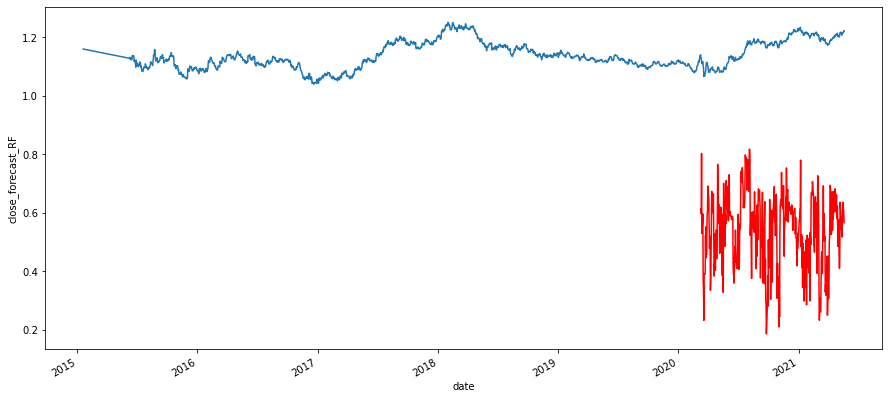

In [18]:
plot_result(best_model_GB, df)

In [19]:
best_model_GB.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.05,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [20]:
best_model_GB.score(X_train, y_train)

0.25164933125125477

In [21]:
y_pred_binary_GB = [0]
for i in range(1, len(y_pred_GB)):
    if y_pred_GB[i] > y_pred_GB[i - 1]:
        y_pred_binary_GB.append(1)
    else:       
        y_pred_binary_GB.append(0)

In [22]:
pred_limit = 200
revenue, revenue_list, successful_deals, deals_overall, profit, actions_list = trade(df, y_pred_binary_GB, train_part, pred_limit)

In [23]:
print(f"revenue, {round(revenue, 2)};\tprofit, {round(profit, 2)}")
print(f"successful deals {successful_deals}, overal dealls: {deals_overall}")
print("% succsess", successful_deals*100/deals_overall)
print("traiding days", len(y_pred_GB[:pred_limit]))

revenue, -1156.61;	profit, 277.12
successful deals 47, overal dealls: 118
% succsess 39.83050847457627
traiding days 200


## Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

In [25]:
param_search = { 
    'n_estimators': [5,10, 25, 50, 75, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(4,15,2)]
}

In [26]:
model = RandomForestRegressor()
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [27]:
y_true = y_test.values
y_pred = best_model.predict(X_test)

regression_results(y_test, y_pred)

explained_variance:  0.0404
mean_squared_log_error:  0.115
r2:  0.033
MAE:  0.4822
MSE:  0.2396
RMSE:  0.4895


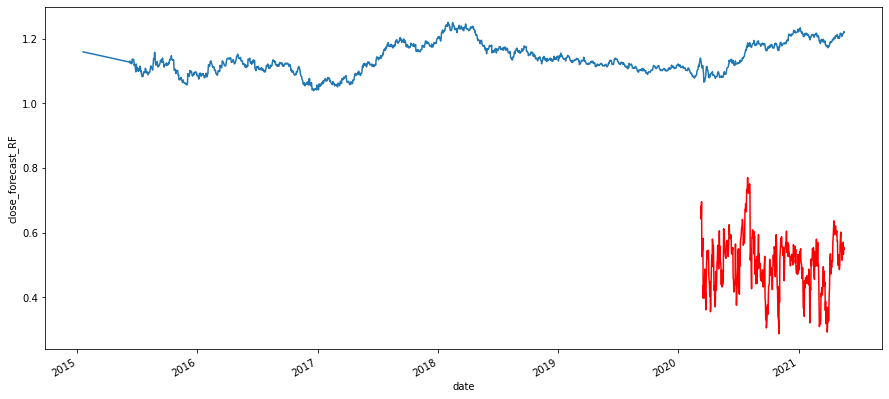

In [28]:
plot_result(best_model, df)

In [29]:
best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 6,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 75,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [30]:
best_model.score(X_train, y_train)

0.22514769987089212

In [31]:
y_pred_binary = [0]
for i in range(1, len(y_pred)):
    if y_pred[i] > y_pred[i - 1]:
        y_pred_binary.append(1)
    else:       
        y_pred_binary.append(0)

In [32]:
pred_limit = 50
revenue, revenue_list, successful_deals, deals_overall, profit, actions_list = trade(df, y_pred_binary, train_part, pred_limit)

In [33]:
print(f"revenue, {round(revenue, 2)};\tprofit, {round(profit, 2)}")
print(f"successful deals {successful_deals}, overal dealls: {deals_overall}")
print("% succsess", successful_deals*100/deals_overall)
print("traiding days", len(y_pred_GB[:pred_limit]))

revenue, -1205.64;	profit, 63.27
successful deals 9, overal dealls: 28
% succsess 32.142857142857146
traiding days 50
